In [1]:
from lmdec import SuccessiveBatchedPowerMethod, PowerMethod
from lmdec.array.random import array_constant_partition, cumulative_partition
import dask.array as da
from time import time
import matplotlib.pyplot as plt

Suppose you have a design matrix, $X$, with $n$ observations of $p$ samples.

<center> $X \in \mathbb{R}^{n \times p}$<\center>
    

It is often desired to see the singular value decompositions of subsets of $X$.

Let $I = \{n_1, n_2, \dots, n_{r-1}, n\}$ which defines subsets of $X$. Therefore, $X_i = X_{0:n_i, :}$
    
We want to see how the SVD of $X_i$ evolves as $i \rightarrow r$.

In [45]:
N, P = 100000, 20000, 
r = 10
k = 10
X = da.random.random(size=(N, P)) 

In [46]:
partitions = cumulative_partition(array_constant_partition(array_shape=(N,P), f=1/r))

Directly computing each Truncated SVD

In [47]:
sub_SVDs = []
start = time()
for i, part in enumerate(partitions):
    PM = PowerMethod(tol=1e-4, scale=False, center=False, factor=None)
    sub_SVDs.append(PM.svd(X[part, :]))
print('Took: {0:.2f} seconds'.format(time() - start))

Took: 1173.35 seconds


In [48]:
SSPM = SuccessiveBatchedPowerMethod(tol=1e-4, scale=False, center=False, factor=None)

In [49]:
start = time()
SSPM.svd(X)
print('Took: {0:.2f} seconds'.format(time() - start))

Took: 600.73 seconds


# Compare Singular Vectors

In [50]:
for i, ((_, S_PM, _), S_SSPM) in enumerate(zip(sub_SVDs, SSPM.history['iter']['S'])):
    acc = (da.linalg.norm(S_PM - S_SSPM)/da.linalg.norm(S_PM)).compute()
    print('Relative Accuracy of SVD(X_{0}): {1:.5f}'.format(i, acc))

Relative Accuracy of SVD(X_0): 0.00002
Relative Accuracy of SVD(X_1): 0.00007
Relative Accuracy of SVD(X_2): 0.00004
Relative Accuracy of SVD(X_3): 0.00014
Relative Accuracy of SVD(X_4): 0.00023
Relative Accuracy of SVD(X_5): 0.00026
Relative Accuracy of SVD(X_6): 0.00023
Relative Accuracy of SVD(X_7): 0.00023
Relative Accuracy of SVD(X_8): 0.00027


# Compare Singular Vectors

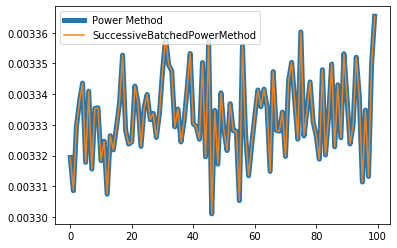

In [52]:
i = 8
plt.plot(sub_SVDs[i][0][0:100, 0], linewidth=5, label='Power Method')
plt.plot(SSPM.sub_svds[i][0][0:100, 0], label = 'SuccessiveBatchedPowerMethod')
plt.legend()